# Thermodynamics Final Project

In [1]:
from thermostate import Q_,State,units

A vapor-compression refrigeration system operating continuously is being considered to provide a minimum of 80 tons of refrigeration for an industrial refrigerator maintaining a space at 8 °C. The system should be sized to reject heat to a reservoir at 27 °C. For effective heat transfer, the system requires a temperature difference of at least 12 °C between the condensing refrigerant and the surroundings and between the vaporizing refrigerant and the refrigerated space. The space must be maintained at a relative humidity of 47%, and air exchange is done with atmospheric at the hot reservoir temperature and a relative humdity of 63%. The system was originally designed to operate with R-22 as the refrigerant, but environmental regulations mean that the refrigerant must be replaced with either ammonia or R-134a.

You are to evaluate the performance of the system with all three refrigerants and determine any changes in operating parameters (pressures, temperatures, work input, COP, etc.) that might improve the overall performance. Make a recommendation of what type of refrigerant should be used in the future. Other than cost to operate the system, what additional factors should the manager consider in making a final selection? Prepare a written report including results, conclusions, and your recommendation.

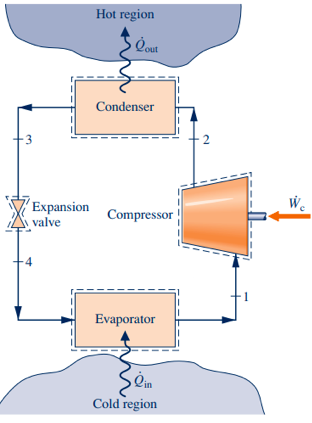

In [2]:
substance = 'r22'

x_f = Q_(0.0, 'dimensionless')
x_g = Q_(1.0, 'dimensionless')

T_C = Q_(8, "degC")
T_H = Q_(27, "degC")

dT = Q_(12, "delta_degC")

Qdot_in = Q_(80, "ton_of_refrigeration")
eta_c = Q_(1, "dimensionless")

|State |$$1$$      |$$2$$      |
|------|-----------|-----------|
|  1   |$$T_1$$    |$$x_1$$    |
|  2s  |$$p_2=p_3$$|$$s_{2s}=s_1$$|
|  2   |$$p_2=p_3$$|$$h_2$$    |
|  3   |$$T_3$$    |$$x_3$$    |
|  4   |$$p_4=p_1$$|$$h_4=h_3$$|

In [3]:
T_3 = T_H + dT
T_1 = T_C - dT

st_3 = State(substance, T=T_3, x=x_f)
st_1 = State(substance, T=T_1, x=x_g)

st_2s = State(substance, p=st_3.p, s=st_1.s)
h_2 = (st_2s.h-st_1.h)/eta_c +st_1.h
st_2 = State(substance, p=st_3.p, h=h_2)
st_4 = State(substance, p=st_1.p, h=st_3.h)

print(st_1.T.to("K"))
print(st_1.s.to("kJ/K/kg"))

269.15 kelvin
1.7565566880308623 kilojoule / kelvin / kilogram


Mass flow rate required to give 80 tons of refrigeration:

$$\dot{Q}_{in} = \dot m (h_1-h_4)$$

In [4]:
mdot_evaporator = Qdot_in/(st_1.h-st_4.h)
print(mdot_evaporator.to("kg/s").round(2))

1.81 kilogram / second


Find the partial pressure of water vapor in the air to ensure a certain humidity level:

*Note: CR means Cold Reservoir*

$$\phi_{CR} = \frac{p_g}{p_{v_{CR}}}$$

In [5]:
phi_CR = Q_(47, "percent")
p_g = State("water", T=T_C, x=x_g).p
p_v_CR = phi_CR * p_g
st_v_CR = State("water", T=T_C, p=p_v_CR)
# 1 atm is the pressure of air and water vapor together
p_a_CR = Q_(1, "atm") - st_v_CR.p
st_a_CR = State("air", T=T_C, p=p_a_CR)                

h_a_CR = st_a_CR.h
h_v_CR = st_v_CR.h

Find the partial pressure of water vapor in the air to ensure a certain humidity level:

*Note: HR means Hot Reservoir*

$$\phi_{HR} = \frac{p_g}{p_{v_{HR}}}$$

In [6]:
phi_HR = Q_(63, "percent")
p_g = State("water", T=T_H, x=x_g).p
p_v_HR = phi_HR * p_g
st_v_HR = State("water", T=T_H, p=p_v_HR)
# 1 atm is the pressure of air and water vapor together
p_a_HR = Q_(1, "atm") - st_v_HR.p
st_a_HR = State("air", T=T_H, p=p_a_HR)

h_a_HR = st_a_HR.h
h_v_HR = st_v_HR.h

Mass Flow rates:

$$\dot m_{a_{HR}} + \dot m_{v_{HR}} = \dot m_{w} + \dot m_{a_{CR}} + \dot m_{v_{CR}}$$

$$\frac{\dot m_w}{\dot m_a} = \omega_{HR} - \omega_{CR}$$

$$0=\dot Q + \sum \dot m_i h_i - \sum \dot m_e h_e$$

$$0=\frac{\dot Q_{out}}{\dot m_{a}} + h_{a_{HR}} +\omega_{HR} h_{v_{HR}} - h_{a_{CR}} - \omega_{CR} h_{v_{CR}} - (\omega_{HR}-\omega_{CR}) h_{w}$$

In [7]:
omega_HR = 0.622*(st_v_HR.p/(Q_(1, "atm")-st_v_HR.p))
omega_CR = 0.622*(st_v_CR.p/(Q_(1, "atm")-st_v_CR.p))

h_w = State("water", T=T_C, x=x_f).h
mdot_a = Q_(400, "feet^3/min")*(1/st_a_HR.v)

In [8]:
Cooling_rate = -(h_a_HR+omega_HR*h_v_HR-h_a_CR-omega_CR*h_v_CR-(omega_HR-omega_CR)*h_w)*mdot_a
print(Cooling_rate.to("ton_of_refrigeration"))

-2.897030517818461 refrigeration_ton


Mass flow rate required to give 10.19 kJ/s to cool air to the correct humidity:

$$CoolingRate = \dot m (h_1-h_4)$$

In [9]:
mdot_dehumidifing = (-Cooling_rate)/(st_1.h-st_4.h)
print(mdot_dehumidifing.to("kg/s").round(2))

0.07 kilogram / second


We will say their is a split in our system from state 4 to state 1, where a majority fraction of the fluid goes to the evaporator but some mass flow rate is broken off to dehumidify the air. This means our total mass flow rate is:

In [10]:
mdot = mdot_dehumidifing + mdot_evaporator
print(mdot.to("kg/s").round(2))

1.88 kilogram / second


### Performance Parameters:

Work Input:

$$\dot W = \dot m (h_1-h_2)$$

COP:

$$\beta = \frac{\dot Q_{in}}{|\dot W_{cycle}|}$$

In [11]:
Wdot = mdot*(st_1.h-st_2.h)
print(Wdot.to("kW"))
beta = (Qdot_in-Cooling_rate)/(-Wdot)
print(beta.to("dimensionless"))

-57.872268500794235 kilowatt
5.037588208097909 dimensionless


In [12]:
print(st_1.p.to("atm"))
print(st_2.p.to("atm"))
print(st_3.p.to("atm"))
print(st_4.p.to("atm"))

4.305760234405386 atmosphere
14.769361905391879 atmosphere
14.769361905391746 atmosphere
4.305760234405386 atmosphere


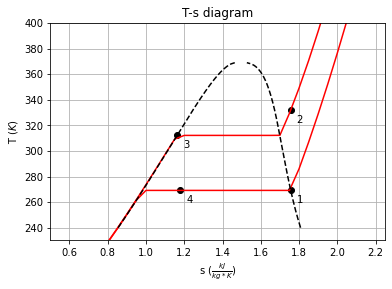

In [13]:
import matplotlib.pyplot as plt
import numpy as np

s_range = np.arange(0.5,2.25,0.05)*(units.kJ/units.kg/units.K)
T_range = np.arange(240,369.295,1)*units.K

def plot_isobar(p):
    result = []
    for i in s_range:
        st_i = State(substance,p=p,s=i)
        result.append(st_i.T.magnitude)
    return result

def plot_satliquid():
    result = []
    for i in T_range:
        st_i = State(substance,T=i,x=Q_(0.0, 'dimensionless'))
        result.append(st_i.s.to("kJ/kg/K").magnitude)
    return result

def plot_satvapor():
    result = []
    for i in T_range:
        st_i = State(substance,T=i,x=Q_(1.0, 'dimensionless'))
        result.append(st_i.s.to("kJ/kg/K").magnitude)
    return result


state = ["1","2","3","4"]
s_points = [st_1.s.to("kJ/kg/K").magnitude,st_2.s.to("kJ/kg/K").magnitude,st_3.s.to("kJ/kg/K").magnitude,
            st_4.s.to("kJ/kg/K").magnitude]
T_points = [st_1.T.magnitude,st_2.T.magnitude,st_3.T.magnitude,st_4.T.magnitude]

colors_list = "kkkk"
for i in range(len(colors_list)):
    plt.plot(s_points[i],T_points[i],colors_list[i]+"o")
    plt.annotate(state[i],(s_points[i]+0.03,T_points[i]-10))

plt.plot(s_range.magnitude,plot_isobar(st_1.p),"r-")
plt.plot(s_range.magnitude,plot_isobar(st_3.p),"r-")
plt.plot(plot_satliquid(),T_range,"k--")
plt.plot(plot_satvapor(),T_range,"k--")

plt.xlim(0.5,2.25)
plt.ylim(230,400)
plt.xlabel("s ($\\frac{kJ}{kg*K}$)")
plt.ylabel("T ($K$)")
plt.title("T-s diagram")
plt.grid(True)
plt.show()

In [14]:
print(beta.to("dimensionless").round(2))
print(Wdot.to("kJ/s").round(2))
print(st_1.p.to("atm").round(2))
print(st_2.p.to("atm").round(2))
print(mdot.to("kg/s").round(2))

5.04 dimensionless
-57.87 kilojoule / second
4.31 atmosphere
14.77 atmosphere
1.88 kilogram / second
